<a href="https://colab.research.google.com/github/ShihaoCui/Mydata_1/blob/main/THM%20Inversion/SolidsPINNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ShihaoCui/MyData_1.git

Cloning into 'MyData_1'...
remote: Enumerating objects: 938, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 938 (delta 87), reused 176 (delta 65), pack-reused 736 (from 1)
Receiving objects: 100% (938/938), 620.36 MiB | 20.19 MiB/s, done.
Resolving deltas: 100% (362/362), done.
Updating files: 100% (358/358), done.


In [2]:
import sys
sys.path.append('/content/THM Inversion/')

In [3]:
"""
Description:
    Utility functions for data preparation.

Created by Ehsan Haghighat on 6/10/20.
"""


import os, time
import sys
import numpy as np
import pandas as pd
from scipy.interpolate import griddata

RADI = 50.0


def eval_mu_sig(X):
    return X.mean(), X.std()

def std(X, mu, sig):
    return (X-mu)/sig

def invstd(X, mu, sig):
    return X*sig + mu

def get_data():
    file_path = "./MyData_1/THM Inversion/plate_with_hole_plastic_output_100x100_p4_mm.txt"
    data = pd.read_csv(file_path, sep='\s+', skiprows=9, dtype='float64')
    return data

def get_data_max():
    data = get_data()
    xcoord = data.x.values
    ycoord = data.y.values
    training_data_ids = np.where((xcoord**2 + ycoord**2 - RADI**2).reshape(-1) > 0)[0]
    data_max = {}
    for v in data.keys():
        data_max[v] = abs(data[v].values[training_data_ids]).max()
    return data_max

def get_training_data(ndata=None, adaptive_sampling=False):
    """ get_training_data
      Inputs:
          ndata: number of training points.
                 defaulted to all available samples.
          adaptive_sampling: pick more points at locations with high-strains.
                             Defaulted to False.
      Returns:
          mu_sig: normalization values (mu, sig) for each component.
          data_s: nomalized data for training.
    """
    data = get_data()

    xcoord = data.x.values
    ycoord = data.y.values
    training_data_ids = np.where((xcoord**2 + ycoord**2 - RADI**2).reshape(-1) > 0)[0]

    if ndata is not None:
      if adaptive_sampling == False:
          training_data_ids = np.random.choice(
              training_data_ids,
              ndata,
              replace=False
          )
      else:
          prob = np.sqrt(sum([data[v].values[training_data_ids]**2 for v in ['exx', 'eyy', 'ezz', 'exy', 'exy', 'plxx', 'plyy', 'plzz', 'plxy']]))
          prob = prob / prob.sum()
          training_data_ids = np.random.choice(
                training_data_ids,
                ndata,
                p = prob,
                replace=False
          )

    xcoord = xcoord[training_data_ids]
    ycoord = ycoord[training_data_ids]

    mu_sig = {'x': [0., 1.], 'y':[0., 1.]}
    data_s = {'x': xcoord, 'y':ycoord}
    for v in ['u', 'v', 'sxx', 'syy', 'szz', 'sxy', 'exx', 'eyy', 'exy', 'plxx', 'plyy', 'plzz', 'plxy']:
        dt_val = data[v].values[training_data_ids]
        mu, sig = eval_mu_sig(dt_val)
        mu_sig[v] = [mu, sig]
        data_s[v] = std(dt_val, mu, sig)

    return mu_sig, data_s

def get_test_data(nx=200, ny=400):
    data = get_data()

    XMIN, XMAX = data.x.values.min(), data.x.values.max()
    YMIN, YMAX = data.y.values.min(), data.y.values.max()

    Xmesh_plot = np.linspace(XMIN, XMAX, nx)
    Ymesh_plot = np.linspace(YMIN, YMAX, ny)

    X_plot, Y_plot = np.meshgrid(Xmesh_plot, Ymesh_plot)

    input_plot = [X_plot.reshape(-1, 1), Y_plot.reshape(-1, 1)]
    nan_ids = np.where(input_plot[0]**2 + input_plot[1]**2 - RADI**2 < 0.0)[0].reshape(-1,1)

    return X_plot, Y_plot, nan_ids


In [4]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


from tqdm  import tqdm
from tqdm import trange

import torch
torch.cuda.empty_cache()

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings

warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False   # 设置显示负号

np.random.seed(2023)

In [5]:
# In[2]:


# 检查是否有可用的GPU设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [6]:
# In[3]:


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=[20, 20, 5], activation='tanh'):
        """
        初始化神经网络模型

        Parameters:
            - input_size (int): 输入特征的维度
            - hidden_size (list): 分别表示隐藏层的神经元数量
            - output_size (int): 输出的维度
        """
        super(NeuralNetwork, self).__init__()

        layers = []
        layers.append(nn.Linear(input_size, hidden_size[0]))

        if activation == 'relu':
            layers.append(nn.ReLU())
        elif activation == 'sigmoid':
            layers.append(nn.Sigmoid())
        elif activation == 'tanh':
            layers.append(nn.Tanh())
        else:
            layers.append(nn.Softplus())


        for i in range(len(hidden_size) - 1):
            layers.append(nn.Linear(hidden_size[i], hidden_size[i+1]))

            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            else:
                layers.append(nn.Softplus())

        layers.append(nn.Linear(hidden_size[-1], output_size))

        # 使用 nn.Sequential 定义网络结构
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """
        定义前向传播过程

        Parameters:
            - x (torch.Tensor): 输入数据张量

        Returns:
            - torch.Tensor: 模型输出的张量
        """
        return self.network(x)


# 均方误差 MSE
mse_loss = torch.nn.MSELoss()

# 定义 MAE 损失(绝对误差)
mae_loss = nn.L1Loss()

In [7]:
# In[4]:


def auto_grad(u, x, order=1):
    """
    计算张量 u 对 x 的梯度

    参数:
        u (torch.Tensor): 需要计算梯度的张量
        x (torch.Tensor): 相对于其计算梯度的张量
        order (int): 梯度的阶数，默认值为 1

    返回:
        torch.Tensor: u 对 x 的梯度
    """
    if order == 1:
        return torch.autograd.grad(
            outputs=u,
            inputs=x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True,
#             only_inputs=True
        )[0]
    else:
        return auto_grad(auto_grad(u, x), x, order=order - 1)

def xavier_init(layer):
    """
    对神经网络层进行 Xavier 初始化，包括权重和偏置

    Parameters:
        - layer (torch.nn.Module): 神经网络层

    Notes:
        该函数用于初始化线性层（nn.Linear），使用 Xavier 初始化方法，即将权重初始化为均匀分布，
        将偏置初始化为零。
    """
    if isinstance(layer, nn.Linear):  # 检查是否为线性层
        nn.init.xavier_uniform_(layer.weight)  # 使用Xavier初始化方法初始化权重
        nn.init.zeros_(layer.bias)  # 将偏置初始化为零


from torch.optim import lr_scheduler
class PINNs():
    def __init__(
        self,
        layers, activation='tanh', device=device,
        initial_lr=0.001, sadap = False,
        lmbd=0, mu=0, sigma_Y=0,
    ):
        """
        初始化物理信息神经网络（PINN）模型。

        参数：
            X（numpy array）：输入特征（空间和时间）。
            u（numpy array）：与X对应的真实解。
            lb（list）：输入特征的下界。
            ub（list）：输入特征的上界。
            layers（list）：神经网络架构的列表。
            activation（str）：隐藏层的激活函数（默认为'tanh'）。
        """
        self.device=device


        # 深度神经网络
        self.dnn = NeuralNetwork(
            input_size=layers[0], output_size= layers[-1], hidden_size=layers[1:-1],
            activation=activation,
        ).to(device)
        self.dnn.apply(xavier_init)

        # 设置
        self.lambda_1 = torch.tensor(lmbd, requires_grad=True, dtype=torch.float32).to(device)
        self.lambda_2 = torch.tensor(mu, requires_grad=True, dtype=torch.float32).to(device)
        self.lambda_3 = torch.tensor(sigma_Y, requires_grad=True, dtype=torch.float32).to(device)

        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        self.lambda_3 = torch.nn.Parameter(self.lambda_3)
        self.dnn.register_parameter('lambda', self.lambda_1)
        self.dnn.register_parameter('mu', self.lambda_2)
        self.dnn.register_parameter('sigma_Y', self.lambda_3)



        self.sadap=sadap #自适应学习率（是否）
        self.optimizer_Adam = torch.optim.Adam(params=self.dnn.parameters(), lr=initial_lr)
        if self.sadap:
            self.scheduler = lr_scheduler.StepLR(self.optimizer_Adam, step_size=1000, gamma=0.9)

        self.iter=0
        self.adam_train_loss = []
    def callback(self, ):
#         print(self.k[0])
        return f", lambda:{torch.exp(self.lambda_1).item():.5f}, mu:{torch.exp(self.lambda_2).item():.5f}, sigma_Y:{torch.exp(self.lambda_3).item():.5f}."

    def closure(self):
        """
        计算损失函数。

        返回：
            tensor：损失值。
        """

        loss = self.lossf(
            model=self.dnn, td=None,params=[self.lambda_1, self.lambda_2, self.lambda_3],
        )

        self.iter += 1
        if self.iter % 100 == 0:
            print(f'Loss: {loss.item():.6f}')

        self.optimizer.zero_grad()
        loss.backward()

        return loss
    def train(self, epochs, lossf):
        """
        训练PINN模型。

        参数：
            epochs（int）：训练周期数。
            lossf（function）：损失函数（默认为mse_loss）。
        """
        #开启训练模式
        self.dnn.train()

        self.lossf = lossf

        with trange(epochs, dynamic_ncols=True, ncols=1) as td:
            for epoch in td:

                loss = self.lossf(
                    model=self.dnn, td=td, params=[self.lambda_1, self.lambda_2, self.lambda_3],
                    print_str=self.callback(),
                )
                self.adam_train_loss.append(loss.item())

                # 反向传播和优化
                self.optimizer_Adam.zero_grad()
#                 if torch.isnan(loss).any():
#                     print("Loss contains NaN values. Check your model and input data.")
                loss.backward()
                self.optimizer_Adam.step()

                if self.sadap:
                    self.scheduler.step()


    def predict(self, X):
        """
        预测给定输入特征的解。

        参数：
            X（numpy array）：输入特征（空间和时间）。

        返回：
            tuple：预测的解。
        """

        # 模型 评估模式
        self.dnn.eval().cpu()

        ret = self.dnn(torch.tensor(X).float()).detach().numpy()

        self.dnn.to(self.device)

        return ret

    def predict1(self, x, y):
        """
        预测给定输入特征的解。

        参数：
            X（numpy array）：输入特征（空间和时间）。

        返回：
            tuple：预测的解。
        """

        # 模型 评估模式
        self.dnn.eval().cpu()
        x = torch.tensor(x, requires_grad=True).float()
        y = torch.tensor(y, requires_grad=True).float()

        uxy = self.dnn(torch.cat([x, y], dim=1))

        u_x_pred = uxy[:, 0].reshape(-1, 1)
        u_y_pred = uxy[:, 1].reshape(-1, 1)

        # Denormalization.
        u_x_pred, u_y_pred = [
            invstd(U, mu_sig[v][0], mu_sig[v][1])
            for U, v in
            zip([u_x_pred, u_y_pred], ['u', 'v'])
        ]

        epsilon_xx_pred = auto_grad(u_x_pred, x, 1).detach().numpy()
        epsilon_yy_pred = auto_grad(u_y_pred, y, 1).detach().numpy()
        epsilon_xy_pred = 0.5*auto_grad(u_y_pred, x, 1) + 0.5*auto_grad(u_x_pred, y, 1)

        epsilon_xy_pred = epsilon_xy_pred.detach().numpy()

        uxy = uxy.detach().numpy()
        self.dnn.to(self.device)


        return uxy, epsilon_xx_pred, epsilon_yy_pred, epsilon_xy_pred

In [8]:
# In[5]:


E_true = 70e3
V_true = 0.2
SY_true = 243.0

Lambda_true = E_true*V_true / (1+V_true) / (1-2*V_true)
G_true = E_true / (1+V_true) / 2
B_true = Lambda_true + 2/3*G_true

# data preparion.
# attached file for accessing data.
# import sys
# import os
# # 获取 THM Inversion 目录的绝对路径
# thm_inversion_path = os.path.abspath('path/to/MyData_1/THM Inversion')
# # 将 THM Inversion 目录添加到 sys.path
# sys.path.append(thm_inversion_path)

# 现在可以导入 utility_functions
# from utility_functions import eval_mu_sig, std, invstd, get_training_data
mu_sig, data_s = get_training_data(ndata=10000, adaptive_sampling=True)




# defining normalization factors.
SBAR = np.min([mu_sig[v][1] for v in ['sxx', 'syy', 'szz', 'sxy']])
UBAR = np.min([mu_sig[v][1] for v in ['u', 'v']])
EBAR = np.min([mu_sig[v][1] for v in ['exx', 'eyy', 'exy']])




lmbd_true = Lambda_true
mu_true =G_true
sigma_Y_true = 243.0




data_s['x'] = data_s['x'].reshape(-1, 1)
data_s['y'] = data_s['y'].reshape(-1, 1)

data_s['v'] = data_s['v'].reshape(-1, 1)
data_s['u'] = data_s['u'].reshape(-1, 1)

data_s['sxx'] = data_s['sxx'].reshape(-1, 1)
data_s['syy'] = data_s['syy'].reshape(-1, 1)
data_s['szz'] = data_s['szz'].reshape(-1, 1)
data_s['sxy'] = data_s['sxy'].reshape(-1, 1)


data_s['exx'] = data_s['exx'].reshape(-1, 1)
data_s['eyy'] = data_s['eyy'].reshape(-1, 1)
data_s['exy'] = data_s['exy'].reshape(-1, 1)

In [9]:
# In[11]:


def interior(device=device):
    """
    生成内部点的坐标和条件

    参数:
        n (int): 内部点数量，默认值为 Nf
        device (torch.device): 张量所在的设备，默认为当前设备

    返回:
        tuple: 包含 x、y, t 坐标和条件 cond 的元组
    """
    x_in = torch.tensor(data_s['x'].reshape(-1, 1), dtype=torch.float32, device=device, requires_grad=True)
    y_in = torch.tensor(data_s['y'].reshape(-1, 1), dtype=torch.float32, device=device, requires_grad=True)

    # 计算条件 cond，根据题目设定的偏微分方程右侧
    cond = torch.zeros_like(x_in)

    return x_in, y_in, cond


def pinn_pde_loss(model, params, interior_fn=interior, loss=mse_loss,):
    """
    计算偏微分方程（PDE）损失函数（内部条件损失）

    参数:
        model (torch.nn.Module): 神经网络模型
        interior_fn (function): 内部点函数，返回内部点坐标和条件

    返回:
        torch.Tensor: PDE损失值
    """

    x, y, cond = interior_fn()

    uxy = model(
        torch.cat(
            [x, y],
            dim=1
        )
    )
#     print(uxy.shape)

    u_x_pred = uxy[:, 0].reshape(-1, 1)
    u_y_pred = uxy[:, 1].reshape(-1, 1)

    sigma_xx_pred = uxy[:, 2].reshape(-1, 1)
    sigma_yy_pred = uxy[:, 3].reshape(-1, 1)
    sigma_zz_pred = uxy[:, 4].reshape(-1, 1)
    sigma_xy_pred = uxy[:, 5].reshape(-1, 1)

    # Denormalization.
    u_x_preds, u_y_preds = [
        invstd(U, mu_sig[v][0], mu_sig[v][1])
        for U, v in
        zip([u_x_pred, u_y_pred], ['u', 'v'])
    ]


    sigma_xx_preds, sigma_yy_preds, sigma_zz_preds, sigma_xy_preds = [
        invstd(S, mu_sig[v][0], mu_sig[v][1])
        for S, v in
        zip([sigma_xx_pred, sigma_yy_pred, sigma_zz_pred, sigma_xy_pred], ['sxx', 'syy', 'szz', 'sxy'])
    ]

    # 应变张量  \varepsilon_{ij}
    epsilon_xx_preds = auto_grad(u_x_preds, x, 1)
    epsilon_yy_preds = auto_grad(u_y_preds, y, 1)
    epsilon_xy_preds = 0.5*auto_grad(u_y_preds, x, 1) + 0.5*auto_grad(u_x_preds, y, 1)
    Evol = epsilon_xx_preds + epsilon_yy_preds
    epsilon_xx_pred, epsilon_yy_pred, epsilon_xy_pred = [
        std(E, mu_sig[v][0], mu_sig[v][1])
        for E, v in
        zip([epsilon_xx_preds, epsilon_yy_preds, epsilon_xy_preds], ['exx', 'eyy', 'exy'])
    ]

    lmbd, mu, sigma_Y  = params
    lmbd, mu, sigma_Y = torch.exp(lmbd), torch.exp(mu), torch.exp(sigma_Y)

    poisson = lmbd / (lmbd + mu) / 2
    bulk = lmbd + 2/3*mu


    # e_{ij} = \varepsilon_{ij} - \varepsilon_{kk}\delta_{ij}/3
    DExx = epsilon_xx_preds - Evol/3
    DEyy = epsilon_yy_preds - Evol/3
    DEzz = -Evol/3
    DExy = epsilon_xy_preds


    # 总等效应变 \bar{\varepsilon}
    DEq = torch.sqrt((DExx**2 + DEyy**2 + DEzz**2 + 2*DExy**2) * (2/3))

    # 塑性乘数|等效塑性应变 \bar{\varepsilon}^p    >= 0约束
    EPE = torch.nn.functional.relu((3*mu*DEq - sigma_Y) / (3*mu))


    # 计算 s_{ij} = \sigma_{ij} - \sigma_{kk}\delta_{ij}/3
    Prs = -(sigma_xx_preds + sigma_yy_preds + sigma_zz_preds)/3
    DSxx = sigma_xx_preds + Prs
    DSyy = sigma_yy_preds + Prs
    DSzz = sigma_zz_preds + Prs
    DSxy = sigma_xy_preds

    # 计算 等效应力q = \sqrt{\frac{3}{2}s_{ij}s_{ij}}
    DSq = torch.sqrt((DSxx**2 + DSyy**2 + DSzz**2 + 2*DSxy**2) * 1.5)


    # e_{ij}^p = \bar{\varepsilon}^p \frac{3 s_{ij}}{2 q},
    PExx = EPE * DSxx / DSq * 1.5   # e_{xx}^P
    PEyy = EPE * DSyy / DSq * 1.5   # e_{yy}^P
    PEzz = EPE * DSzz / DSq * 1.5   # e_{zz}^P
    PExy = EPE * DSxy / DSq * 1.5   # e_{xy}^P

    # Yield function.
    F = DSq - (sigma_Y)

    # \sigma_{ij,j} + f_i
    Lx = auto_grad(sigma_xx_preds, x, 1) + auto_grad(sigma_xy_preds, y, 1)
    Ly = auto_grad(sigma_xy_preds, x, 1) + auto_grad(sigma_yy_preds, y, 1)



    loss_pde = loss(cond, Prs/SBAR + (lmbd + mu*2/3)/SBAR*Evol) +\
                loss(cond, DSxx/SBAR - 2*mu/SBAR*(DExx - PExx)) +\
                loss(cond, DSyy/SBAR - 2*mu/SBAR*(DEyy - PEyy)) +\
                loss(cond, DSzz/SBAR - 2*mu/SBAR*(DEzz - PEzz)) +\
                loss(cond, DSxy/SBAR - 2*mu/SBAR*(DExy - PExy)) +\
                loss(cond, torch.nn.functional.relu(F/SBAR)) +\
                loss(cond, Lx/SBAR) + loss(cond, Ly/SBAR)


    loss_u_x = loss(u_x_pred, torch.tensor(data_s['u'], dtype=torch.float32, device=device))
    loss_u_y = loss(u_y_pred, torch.tensor(data_s['v'], dtype=torch.float32, device=device))
    loss_sigma_xx = loss(sigma_xx_pred, torch.tensor(data_s['sxx'], dtype=torch.float32, device=device))
    loss_sigma_yy = loss(sigma_yy_pred, torch.tensor(data_s['syy'], dtype=torch.float32, device=device))
    loss_sigma_zz = loss(sigma_zz_pred, torch.tensor(data_s['szz'], dtype=torch.float32, device=device))
    loss_sigma_xy = loss(sigma_xy_pred, torch.tensor(data_s['sxy'], dtype=torch.float32, device=device))
    loss_epsilon_xx = loss(epsilon_xx_pred, torch.tensor(data_s['exx'], dtype=torch.float32, device=device))
    loss_epsilon_yy = loss(epsilon_yy_pred, torch.tensor(data_s['eyy'], dtype=torch.float32, device=device))
    loss_epsilon_xy = loss(epsilon_xy_pred, torch.tensor(data_s['exy'], dtype=torch.float32, device=device))

    loss_data = loss_u_x + loss_u_y +\
                loss_sigma_xx + loss_sigma_yy + loss_sigma_zz + loss_sigma_xy +\
                loss_epsilon_xy + loss_epsilon_xx + loss_epsilon_yy


    return loss_pde, loss_data

In [10]:
# In[16]:


def get_pinn_loss(model, params, td=None, print_str="",):

    loss_F, loss_Data = pinn_pde_loss(
        model=model,
        interior_fn=interior,
        params=params,
    )


    loss_all = loss_F + loss_Data

    if td is not None:
        td.set_description(f"pde: {loss_F.item():.5f}, data_loss: {loss_Data.item():.5f}, 总的: {loss_all.item():.6f}"+print_str)

    return loss_all

In [11]:
# In[17]:

np.random.rand()

0.8048476898773458

pde: 0.00591, data_loss: 0.01174, 总的: 0.017649, lambda:19155.43945, mu:28768.19922, sigma_Y:242.75079.: 100%|██████████| 100000/100000 [51:46<00:00, 32.19it/s]


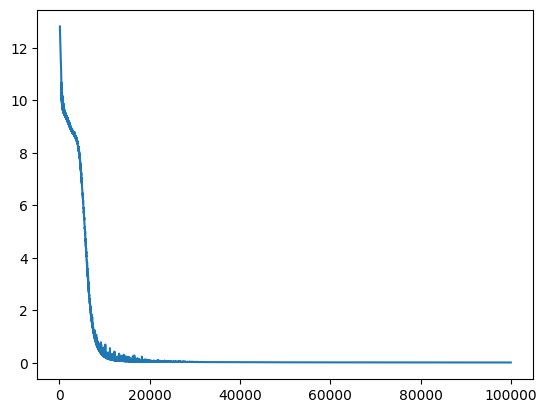

In [12]:
# In[18]:

# %% time
# lmbd_true = Lambda_true
# mu_true =G_true
# sigma_Y_true = 243.0


layers = [2, 100, 100, 100, 100, 6]
model = PINNs(
    layers=layers, activation='tanh', device=device,
    sadap=True, initial_lr=0.001,
#     lmbd=lmbd_true*np.random.rand(), mu=mu_true*np.random.rand(), sigma_Y=np.random.rand()*sigma_Y_true,
    lmbd = 0, mu = 0, sigma_Y = 0,
)

model.train(epochs=100000, lossf=get_pinn_loss)



lll = len(model.adam_train_loss)

l = 100
r = lll

plt.plot(range(l, r),model.adam_train_loss[l:r])

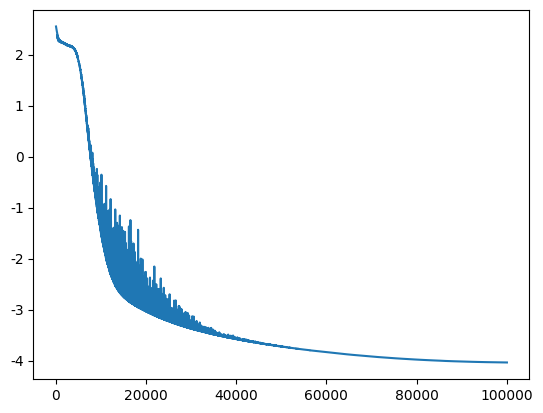

In [13]:
# In[24]:
plt.plot(range(l, r), np.log(model.adam_train_loss[l:r]))


In [14]:
# In[25]:


def relu_np(array):
    """
    Apply the ReLU function to a NumPy array.

    Parameters:
    - array: A NumPy array on which ReLU will be applied.

    Returns:
    - A NumPy array with the ReLU function applied.
    """
    return np.maximum(0, array)

In [20]:
# In[26]:


# from utility_functions import get_test_data

X_plot, Y_plot, nan_ids = get_test_data(200, 400)

uxy, epsilon_xx_pred, epsilon_yy_pred, epsilon_xy_pred = model.predict1(X_plot.flatten()[:,None], Y_plot.flatten()[:,None])



epsilon_xx_pred = epsilon_xx_pred.reshape(-1, 1)
epsilon_xx_pred[nan_ids] = float('nan')

epsilon_yy_pred = epsilon_yy_pred.reshape(-1, 1)
epsilon_yy_pred[nan_ids] = float('nan')

epsilon_xy_pred = epsilon_xy_pred.reshape(-1, 1)
epsilon_xy_pred[nan_ids] = float('nan')

u_x_pred = uxy[:, 0].reshape(-1, 1)
u_y_pred = uxy[:, 1].reshape(-1, 1)
# Denormalization.
u_x_pred, u_y_pred = [
    invstd(U, mu_sig[v][0], mu_sig[v][1])
    for U, v in
    zip([u_x_pred, u_y_pred], ['u', 'v'])
]
u_x_pred[nan_ids] = float('nan')
u_y_pred[nan_ids] = float('nan')



sigma_xx_pred = uxy[:, 2].reshape(-1, 1)
sigma_yy_pred = uxy[:, 3].reshape(-1, 1)
sigma_zz_pred = uxy[:, 4].reshape(-1, 1)
sigma_xy_pred = uxy[:, 5].reshape(-1, 1)
# Denormalization.
sigma_xx_pred, sigma_yy_pred, sigma_zz_pred, sigma_xy_pred = [
    invstd(S, mu_sig[v][0], mu_sig[v][1])
    for S, v in
    zip([sigma_xx_pred, sigma_yy_pred, sigma_zz_pred, sigma_xy_pred], ['sxx', 'syy', 'szz', 'sxy'])
]
sigma_xx_pred[nan_ids] = float('nan')
sigma_yy_pred[nan_ids] = float('nan')
sigma_xy_pred[nan_ids] = float('nan')
sigma_zz_pred[nan_ids] = float('nan')




import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 1))

def custom_pcolor(AX, X, Y, Z, title="", bar=True, ZLIM=None, **kwargs):
    Z = Z.reshape(X.shape)
    ZLIM = np.abs(Z).max() if ZLIM is None else ZLIM
    if 'vmin' in kwargs:
        im = AX.pcolor(X, Y, Z, cmap="seismic", **kwargs)
    else:
        im = AX.pcolor(X, Y, Z, cmap="seismic",
                       norm=Normalize(vmin=-ZLIM, vmax=ZLIM),
                       **kwargs)
    AX.axis("equal")
    AX.axis([X.min(), X.max(), Y.min(), Y.max()])
    AX.get_xaxis().set_ticks([])
    AX.get_yaxis().set_ticks([])
    AX.set_title(title, fontsize=14)
    if bar:
        clb = plt.colorbar(im, ax=AX)
        clb.formatter.set_powerlimits((0, 0))
    return im

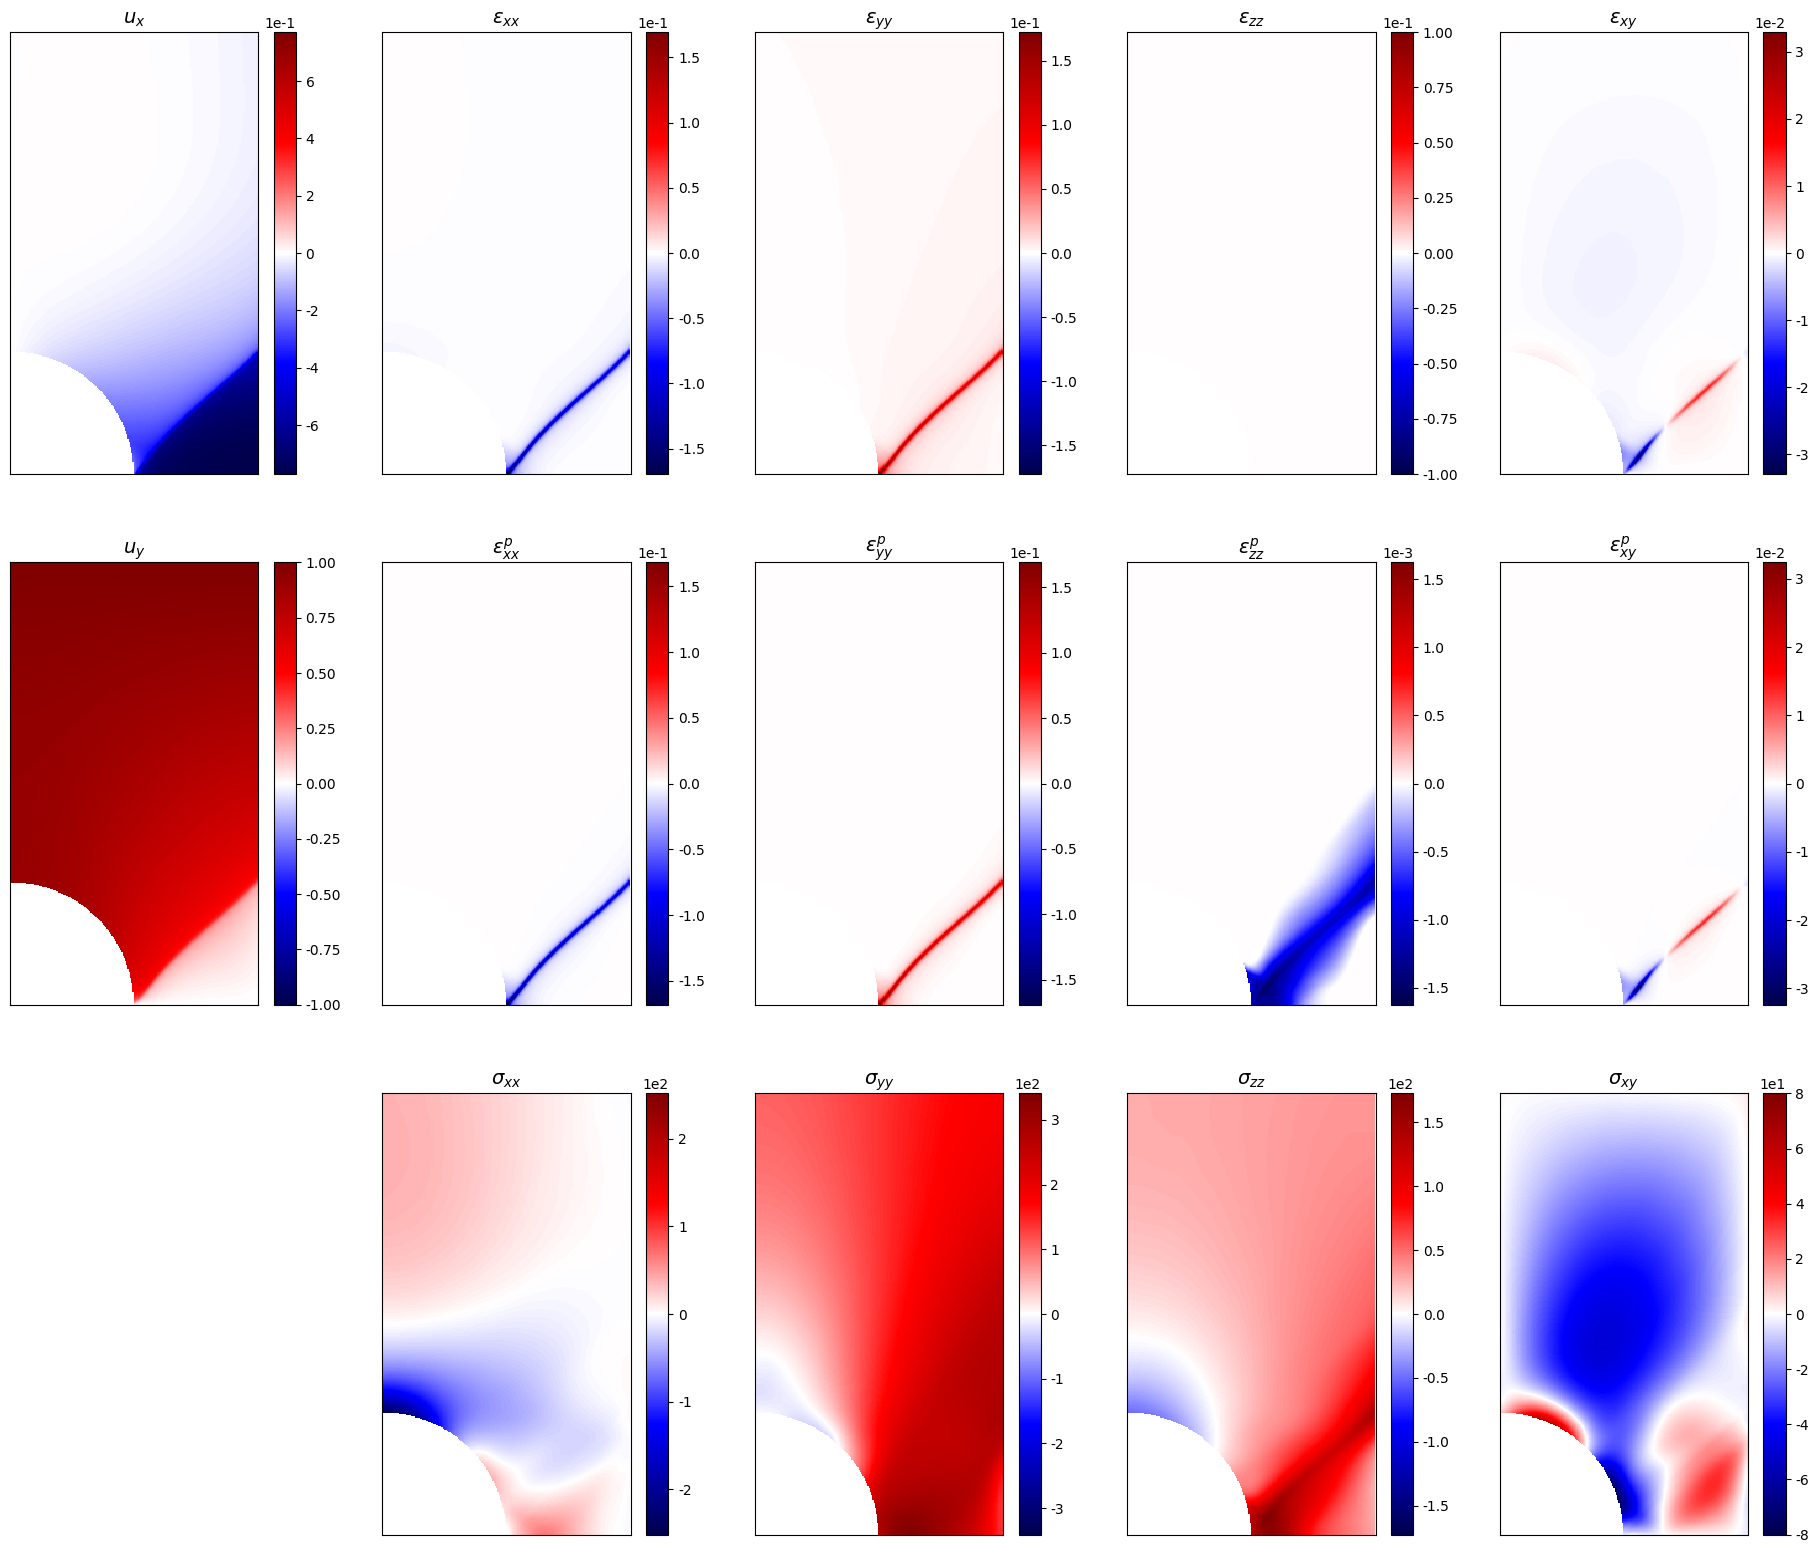

In [22]:
# In[30]:


Evol = epsilon_xx_pred + epsilon_yy_pred
lmbd = torch.exp(model.lambda_1).item()
mu = torch.exp(model.lambda_2).item()
sigma_Y = torch.exp(model.lambda_3).item()

poisson = lmbd / (lmbd + mu) / 2
bulk = lmbd + 2/3*mu

DExx = epsilon_xx_pred - Evol/3
DEyy = epsilon_yy_pred - Evol/3
DEzz = -Evol/3
DExy = epsilon_xy_pred
DEq = np.sqrt((DExx**2 + DEyy**2 + DEzz**2 + 2*DExy**2) * (2/3))
EPE = relu_np((3*mu*DEq - sigma_Y) / (3*mu))

Prs = -(sigma_xx_pred + sigma_yy_pred + sigma_zz_pred)/3
DSxx = sigma_xx_pred + Prs
DSyy = sigma_yy_pred + Prs
DSzz = sigma_zz_pred + Prs
DSxy = sigma_xy_pred
DSq = np.sqrt((DSxx**2 + DSyy**2 + DSzz**2 + 2*DSxy**2) * 1.5)

#     print("EPE type:", type(EPE))
#     print("DSxx type:", type(DSxx))
#     print("DSq type:", type(DSq))
# Plastic strain components.
PExx_pred = EPE * DSxx / DSq * 1.5
PEyy_pred = EPE * DSyy / DSq * 1.5
PEzz_pred = EPE * DSzz / DSq * 1.5
PExy_pred = EPE * DSxy / DSq * 1.5

Upred = [u_x_pred, u_y_pred]
Epred = [epsilon_xx_pred, epsilon_yy_pred, epsilon_xx_pred*0.0, epsilon_xy_pred]
PEpred = [PExx_pred, PEyy_pred, PEzz_pred, PExy_pred]
Spred = [sigma_xx_pred, sigma_yy_pred, sigma_zz_pred, sigma_xy_pred]

# some bounds to easily compare to true values.
# from utility_functions import get_data_max
data_max = get_data_max()

fig, ax = plt.subplots(3, 5, figsize=(20, 16.7))

im = custom_pcolor(ax[0, 0], X_plot, Y_plot, Upred[0], "$u_x$", True, data_max['u'])
im = custom_pcolor(ax[1, 0], X_plot, Y_plot, Upred[1], "$u_y$", True, data_max['v'])
ax[2, 0].axis('off')

im = custom_pcolor(ax[0, 1], X_plot, Y_plot, Epred[0], "$\\varepsilon_{xx}$", True, data_max['exx'])
im = custom_pcolor(ax[0, 2], X_plot, Y_plot, Epred[1], "$\\varepsilon_{yy}$", True, data_max['eyy'])
im = custom_pcolor(ax[0, 3], X_plot, Y_plot, Epred[2], "$\\varepsilon_{zz}$", True, data_max['ezz'])
im = custom_pcolor(ax[0, 4], X_plot, Y_plot, Epred[3], "$\\varepsilon_{xy}$", True, data_max['exy'])

im = custom_pcolor(ax[1, 1], X_plot, Y_plot, PEpred[0], "$\\varepsilon_{xx}^p$", True, data_max['plxx'])
im = custom_pcolor(ax[1, 2], X_plot, Y_plot, PEpred[1], "$\\varepsilon_{yy}^p$", True, data_max['plyy'])
im = custom_pcolor(ax[1, 3], X_plot, Y_plot, PEpred[2], "$\\varepsilon_{zz}^p$", True, data_max['plzz'])
im = custom_pcolor(ax[1, 4], X_plot, Y_plot, PEpred[3], "$\\varepsilon_{xy}^p$", True, data_max['plxy'])

im = custom_pcolor(ax[2, 1], X_plot, Y_plot, Spred[0], "$\\sigma_{xx}$", True, data_max['sxx'])
im = custom_pcolor(ax[2, 2], X_plot, Y_plot, Spred[1], "$\\sigma_{yy}$", True, data_max['syy'])
im = custom_pcolor(ax[2, 3], X_plot, Y_plot, Spred[2], "$\\sigma_{zz}$", True, data_max['szz'])
im = custom_pcolor(ax[2, 4], X_plot, Y_plot, Spred[3], "$\\sigma_{xy}$", True, data_max['sxy'])

fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.2, hspace=0.2)

plt.savefig('./out.png')


# In[ ]: